In [ ]:
# работа с файлами
import os
from google.colab import files
import json


# обработка и рисование изображений
import imageio
from PIL import Image

# рисование графиков
import matplotlib.pyplot as plt

# для работы с массивами и таблицами
import numpy as np 
import pandas as pd

# для создание модели
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2


# Слои, которые потребуются 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, \
Conv2DTranspose, concatenate, Reshape, LeakyReLU

from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split

import cv2
from google.colab.patches import cv2_imshow

import random

import time


# Необходимые функции

In [ ]:
# функция для замены пустых списков на None
def remove_empty_lists(x):
    if isinstance(x, list) and len(x) == 0:
        return None
    else:
        return x

In [ ]:
# функция для замены пустых словарей на None
def remove_empty_dict(x):
    if isinstance(x, dict) and len(x) == 0:
        return None
    else:
        return x

In [ ]:
# фукнция для обработки json файла и создания датафрейма
def df_input(name):
  df_new = pd.DataFrame()
  
  # открытие json файла
  with open(name, 'r') as f:
      data = pd.read_json(f, orient='index', typ='series').reset_index()
      df = pd.DataFrame(data.values.tolist(), columns=['key', 'value'])
      if '_via_img_metadata' in df['key'].tolist(): # если json файл был неправильно скачен с приложения, где проводилась разметка
        dict_data = df.query("key == '_via_img_metadata'").value[1]

        # создаем датафрейм из словаря
        df = pd.DataFrame.from_dict(dict_data, orient='index')
        df_new = df.drop(labels=['file_attributes'], axis=1)

      else: # если json файл был верно скачен 
        df_new[['filename', 'size', 'regions']] = df['value'].apply(pd.Series)[['filename', 'size', 'regions']]
  
  df = pd.DataFrame()
  df = df_new

  # удаление пустых списков
  df.regions = df['regions'].apply(remove_empty_lists)
  df = df.dropna()

  # Развернуть столбец regions
  regions_df = df.explode('regions')

  # Получить значения ключей словарей
  regions_df = pd.concat([regions_df.drop(['regions'], axis=1), regions_df['regions'].apply(pd.Series)], axis=1)

  # удаление пустых словарей
  regions_df.region_attributes = regions_df.region_attributes.apply(remove_empty_dict)
  regions_df = regions_df.dropna()

  # Вывести результат
  return regions_df

In [ ]:
# функция присвоения класса пикселю
def convert_to_labels(image):
    labels = np.zeros((siz, siz), dtype=int)
    for i in range(siz):
        for j in range(siz):
            if np.array_equal(image[i][j], [0, 0, 0]):
                labels[i][j] = 0  # черный пиксель
            elif np.array_equal(image[i][j], [0, 255, 0]):
                labels[i][j] = 1  # зеленый пиксель
            elif np.array_equal(image[i][j], [0, 0, 255]):
                labels[i][j] = 2  # красный пиксель
    return labels

In [ ]:
# функция наделения пикселя цветом по классу
def convert_to_image(image):
    labels = np.zeros((siz, siz, 3), dtype=int)
    for i in range(siz):
        for j in range(siz):
            if image[i][j] == 0:
                labels[i][j] = [0, 0, 0]  # черный пиксель
            elif image[i][j] == 1:
                labels[i][j] = [0, 255, 0]  # зеленый пиксель
            elif image[i][j] == 2:
                labels[i][j] = [0, 0, 255]  # красный пиксель
    return labels

# Загрузка и обработка файлов, создание датафрейма

In [ ]:
uploaded = files.upload()

Saving 00100.PNG to 00100.PNG
Saving 100-130.json to 100-130.json
Saving 00101.PNG to 00101.PNG
Saving 00102.PNG to 00102.PNG
Saving 00103.PNG to 00103.PNG
Saving 00104.PNG to 00104.PNG
Saving 00105.PNG to 00105.PNG
Saving 00106.PNG to 00106.PNG
Saving 00107.PNG to 00107.PNG
Saving 00108.PNG to 00108.PNG
Saving 00109.PNG to 00109.PNG
Saving 00110.PNG to 00110.PNG
Saving 00111.PNG to 00111.PNG
Saving 00112.PNG to 00112.PNG
Saving 00113.PNG to 00113.PNG
Saving 00114.PNG to 00114.PNG
Saving 00115.PNG to 00115.PNG
Saving 00116.PNG to 00116.PNG
Saving 00117.PNG to 00117.PNG
Saving 00118.PNG to 00118.PNG
Saving 00119.PNG to 00119.PNG
Saving 00120.PNG to 00120.PNG
Saving 00121.PNG to 00121.PNG
Saving 00122.PNG to 00122.PNG
Saving 00123.PNG to 00123.PNG
Saving 00124.PNG to 00124.PNG
Saving 00125.PNG to 00125.PNG
Saving 00126.PNG to 00126.PNG
Saving 00127.PNG to 00127.PNG
Saving 00128.PNG to 00128.PNG
Saving 00129.PNG to 00129.PNG
Saving 00130.PNG to 00130.PNG
Saving 00301.PNG to 00301.PNG
Savi

In [ ]:
# список json файлов с разметкой
list_name_df = ['100-130.json','301-335.json','00599-00629.json','950-980.json','02228-02257.json','02800-02835.json','2970-2999.json','3330-3360.json']

In [ ]:
df = pd.DataFrame()
for i in list_name_df:
  df = pd.concat([df,df_input(i)]) # объединим датафреймы в один (с извлечением данных из json)
df

,filename,size,shape_attributes,region_attributes
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [176, 172,...",{'intervertebral disc': '1'}
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [169, 170,...",{'intervertebral disc': '1'}
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [158, 155,...",{'intervertebral disc': '1'}
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [173, 172,...",{'spinal canal': '2'}
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [169, 171,...",{'spinal canal': '2'}
...,...,...,...,...
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [136, 139,...",{'кость': '1'}
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [158, 177,...",{'кость': '1'}
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [191, 193,...",{'диск': '2'}
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [194, 200,...",{'кость': '1'}


In [ ]:
# вынесение атрибута из словаря
list_r = []
for i in df.region_attributes:
  if ' '.join(i.keys()) == 'intervertebral disc': list_r.append(2)
  elif ' '.join(i.keys()) == 'invertebral_disk': list_r.append(2)
  elif ' '.join(i.keys()) == 'spinal canal': list_r.append(1)
  elif ' '.join(i.keys()) == 'spinal_canal': list_r.append(1)
  elif ' '.join(i.keys()) == 'intervertebral disc': list_r.append(2)
  elif ' '.join(i.keys()) == 'spine': list_r.append(1)
  elif ' '.join(i.keys()) == 'Spine': list_r.append(i['Spine'])
  elif ' '.join(i.keys()) == 'spine disc': list_r.append(2)
  elif 'spinal disc' in ' '.join(i.keys()): list_r.append(2)
  elif 'verteba' in ' '.join(i.keys()): list_r.append(1)
  elif ' '.join(i.keys()) == 'Bone': list_r.append(1)
  elif ' '.join(i.keys()) == 'Normal disk': list_r.append(2)
  elif ' '.join(i.keys()) == 'Pathological disk': list_r.append(2)
  elif ' '.join(i.keys()) == 'Herniation': list_r.append(2)
  elif 'кость' in ' '.join(i.keys()): list_r.append(2)
  elif 'диск' in ' '.join(i.keys()): list_r.append(1)
  else:print(' '.join(i.keys()))

df['region_attributes'] = df['region_attributes'].replace(df['region_attributes'].values, list_r)
df['region_attributes'] = df['region_attributes'].astype(int)

In [ ]:
df

,filename,size,shape_attributes,region_attributes
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [176, 172,...",2
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [169, 170,...",2
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [158, 155,...",2
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [173, 172,...",1
100,00100.PNG,71632,"{'name': 'polygon', 'all_points_x': [169, 171,...",1
...,...,...,...,...
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [136, 139,...",2
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [158, 177,...",2
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [191, 193,...",1
03360.PNG66490,03360.PNG,66490,"{'name': 'polygon', 'all_points_x': [194, 200,...",2


# Обработка изображения, создание маски

In [ ]:
# размер изображения
siz = 128

# Создать словарь с цветами для каждого типа контура
colors = {
    1: (0, 255, 0),   # зеленый цвет для типа 1 (позвонок)
    2: (0, 0, 255)    # красный цвет для типа 2 (межпозвоночный диск)
}
# Создать список путей к изображениям, которые необходимо обработать
image_paths = list(df.filename.drop_duplicates())
images = []
mask_ = []

for image_path in image_paths:

    # Загрузить изображение и получить его ширину и высоту
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Создать пустую маску для данного изображения
    mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Найти все строки в DataFrame с соответствующим путем к файлу
    rows = df.loc[df['filename'] == os.path.basename(image_path)]

    # Создать маску для каждого объекта на изображении (если есть)
    for i, row in rows.iterrows():
        # Прочитать тип контура из строки в DataFrame
        contour_type = row['region_attributes']

        # Преобразовать данные маски в массив координат
        vertices = row['shape_attributes']
        all_points_x = vertices['all_points_x']
        all_points_y = vertices['all_points_y']

        # Преобразовать координаты `x` и `y` в массив numpy и создать массив координат для заполнения контура
        pts = np.array(list(zip(all_points_x, all_points_y)))
        pts_for_fill = pts.reshape((-1, 1, 2))

        # Заполнить контур цветом в зависимости от типа
        color = colors.get(contour_type, (255, 255, 255))  # если тип контура не найден в словаре, использовать белый цвет
        cv2.fillPoly(mask, [pts_for_fill], color=color)

    image = cv2.resize(image, (siz, siz))
    mask = cv2.resize(mask, (siz, siz))


    # Нормализовать значения пикселей для изображения и маски
    images.append(image/255.0)
    mask_.append(mask)


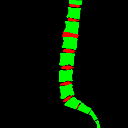

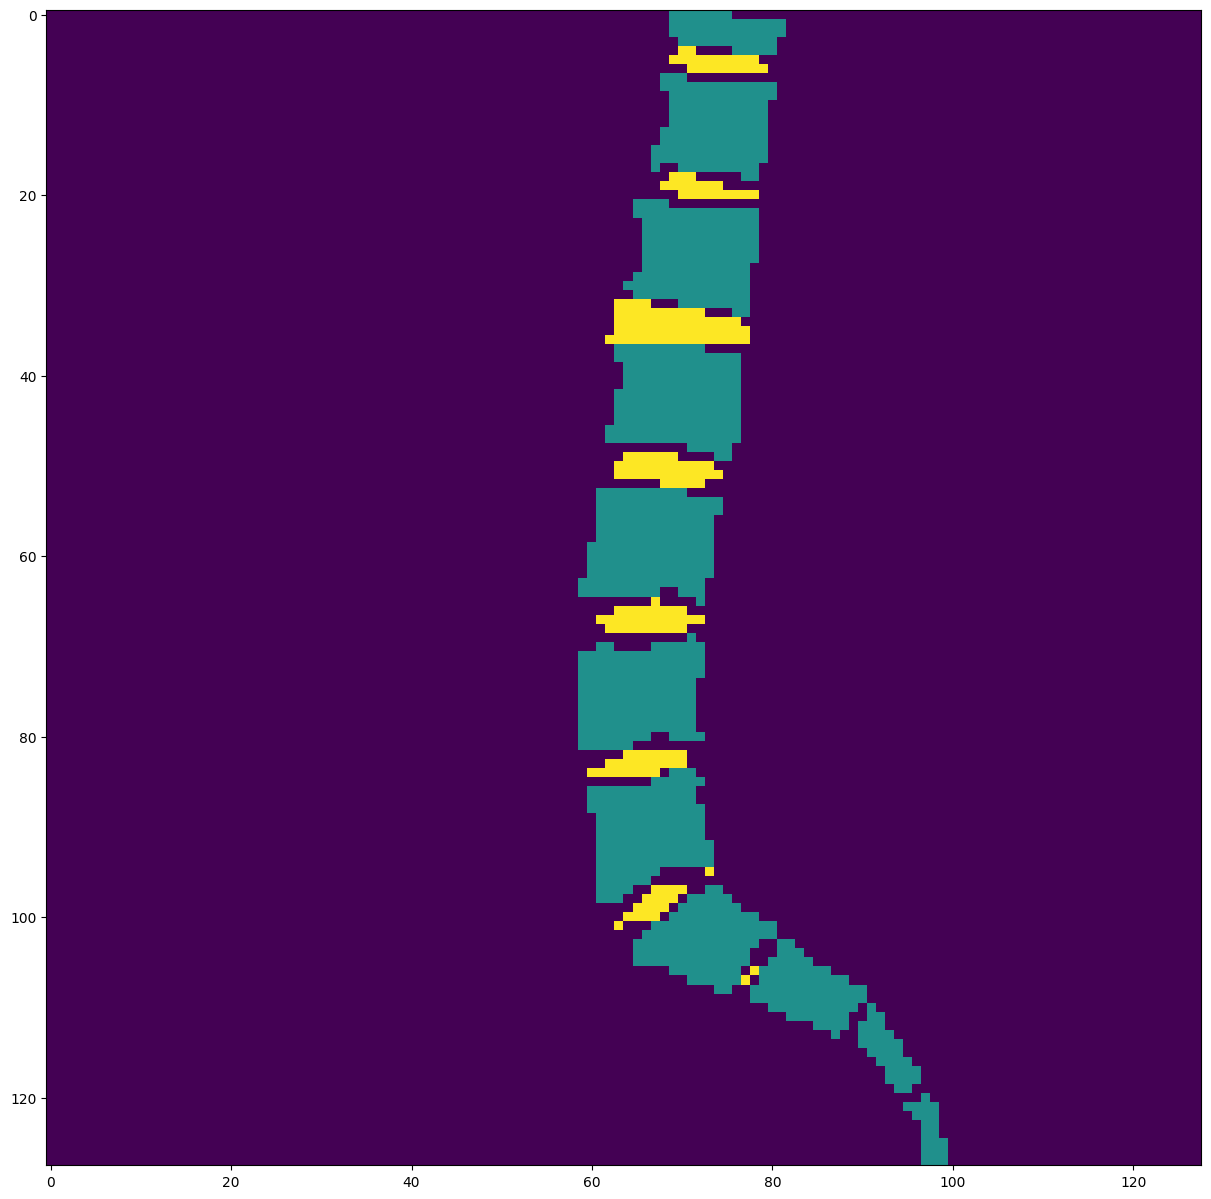

In [ ]:
# Объединить все изображения и маски в один массив numpy
images = np.array(images)
mask_ = np.array(mask_)
cv2_imshow(mask_[0])

masks_ = []
for i in range(len(mask_)):
    mask = mask_[i]
    masks_.append(convert_to_labels(mask)) # преобразовать пиксели в маске в класс
# преобразование в np массив и проверка на правильность классов
masks_ = np.array(masks_)

# просмотр маски
fig, arr = plt.subplots(1, 1, figsize=(15, 15))
arr.imshow(masks_[0])

masks = []
for i in range(len(masks_)):
    # Извлечь отдельную маску
    masks.append(np.reshape(masks_[i],(siz,siz,1))) # расширение размерности масок
masks = np.array(masks) # преобразование в np массив

# Сверточная нейронная сеть на основе предобученной модели 

In [ ]:
# Загрузим предобученную модель MobileNetV2
base_model = MobileNetV2(input_shape=(siz, siz, 3), include_top=False)

# Нам нужно заморозить веса базовой модели, чтобы не обновлять их в процессе обучения нашей новой модели.
for layer in base_model.layers:
    layer.trainable = False

def UNet_(input_size=(siz, siz, 3), n_filters=16, growth_factor=2, n_classes=3):
    
    # Сначала создадим входной слой для нашей модели
    x1 = base_model.get_layer('block_1_expand_relu').output       # [None, 128, 128, 96]
    x2 = base_model.get_layer('block_2_expand_relu').output       # [None, 64, 64, 144]
    x3 = base_model.get_layer('block_4_expand_relu').output       # [None, 32, 32, 192]
    x4 = base_model.get_layer('block_8_expand_relu').output      # [None, 16, 16, 384]

    # Аттрибут model.layers позволяет получить все слои модели. 
    # Нам нужны только первые 4 слоев, которые мы можем назвать как encoder.
    encoder_layers = [base_model.get_layer(f'block_{i}_expand_relu').output
                      for i in [1, 2, 4, 8]]
    # Разворачиваем последний слой Unet
    x = Conv2DTranspose(n_filters*8, 5, strides=growth_factor, padding='same', activation=LeakyReLU(alpha=0.1))(base_model.output)
    x = Dropout(rate=0.2)(x)
    # Присоединяем развернутый слой с concatenation к первым слоям Unet
    x = concatenate([x4, x])
    x = Conv2DTranspose(n_filters*4, 5, strides=growth_factor, padding='same', activation=LeakyReLU(alpha=0.1))(x)
    x = Dropout(rate=0.2)(x)
    x = concatenate([x3, x])
    x = Conv2DTranspose(n_filters*2, 5, strides=growth_factor, padding='same', activation=LeakyReLU(alpha=0.1))(x)
    x = Dropout(rate=0.2)(x)
    x = concatenate([x2, x])
    x = Conv2DTranspose(n_filters, 5, strides=growth_factor, padding='same', activation=LeakyReLU(alpha=0.1))(x)
    x = Dropout(rate=0.2)(x)
    x = concatenate([x1, x])
    x = Conv2DTranspose(n_filters, 5, strides=growth_factor, padding='same', activation=LeakyReLU(alpha=0.1))(x)
    output = Conv2D(n_classes, 3, activation='sigmoid', padding='same')(x)
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=tf.keras.optimizers.Nadam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
    return model
UNet_().summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)             

# Обучение модели 

In [ ]:
# Разделите данные на тренировочный набор и тестовый набор
images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.2, random_state=random.randint(1,100))
print(images_train.shape)
print(mask_train.shape)

(204, 128, 128, 3)
(204, 128, 128, 1)


In [ ]:
# Компилировать модель и обучить ее на тренировочном наборе данных:
unet = UNet_()
start_time = time.time()
results = unet.fit(images_train, mask_train, batch_size=4, epochs=30, validation_data=(images_test, mask_test))
print("Execution time: %s seconds" % (time.time() - start_time))

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


51/51 [==============================] - 41s 638ms/step - loss: 0.2196 - accuracy: 0.9299 - val_loss: 0.1515 - val_accuracy: 0.9390
Epoch 2/30
51/51 [==============================] - 30s 593ms/step - loss: 0.1079 - accuracy: 0.9544 - val_loss: 0.0994 - val_accuracy: 0.9583
Epoch 3/30
51/51 [==============================] - 27s 539ms/step - loss: 0.0958 - accuracy: 0.9589 - val_loss: 0.0983 - val_accuracy: 0.9569
Epoch 4/30
51/51 [==============================] - 28s 548ms/step - loss: 0.0895 - accuracy: 0.9617 - val_loss: 0.0915 - val_accuracy: 0.9631
Epoch 5/30
51/51 [==============================] - 30s 592ms/step - loss: 0.0842 - accuracy: 0.9641 - val_loss: 0.0854 - val_accuracy: 0.9652
Epoch 6/30
51/51 [==============================] - 27s 541ms/step - loss: 0.0822 - accuracy: 0.9649 - val_loss: 0.0906 - val_accuracy: 0.9618
Epoch 7/30
51/51 [==============================] - 30s 592ms/step - loss: 0.0752 - accuracy: 0.9682 - val_loss: 0.0798 - val_accuracy: 0.9684
Epoch 8/30

# Загрузка проверочного изображения, и проверка работы модели

In [ ]:
uploaded = files.upload()

Saving 00000.PNG to 00000.PNG


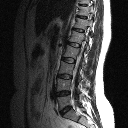

1/1 [==============================] - 1s 1s/step


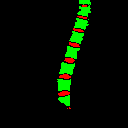

In [ ]:
# Загрузить изображение и получить его ширину и высоту
image_ = cv2.imread('00000.PNG')
height, width = image_.shape[:2]
image_ = cv2.resize(image_, (siz, siz))
cv2_imshow(image_)
image_ = image_ /255.0
img = image_[np.newaxis, ...] # добавляем измерение примеров
pred_y = unet.predict(img)*255.0 # расчитываем маску
pred_mask = tf.argmax(pred_y[0], axis=-1) # выбираем максимальный класс (канал - последнее измерение)
pred_mask = pred_mask[..., tf.newaxis] # канальное измерение добавляе
pred_mask = convert_to_image(pred_mask)
cv2_imshow(pred_mask)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
# сохранить изображение на диск
cv2.imwrite('image_.jpg', image_*255)
cv2.imwrite('pred_mask.jpg', pred_mask)

# загрузить файл на локальный компьютер
files.download('image_.jpg')
files.download('pred_mask.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>